# Few-Shot Learning with Presto

## Notebook Overview 

1) Short introduction on Foundation Models and Presto
2) Definition of Few-Shot learning
3) Apply Presto to perfrom Few-Shot learning on a regression and a classification task

### 1) Foundation Models

A Foundation Model is a model trained on large and diverse unlabeled datasets to learn general patterns and features of the data. Thanks to its strong generalization capabilities, such a model can be adapted for a wide range of applications that use similar types of input data.

**Presto** (**P**retrained **Re**mote **S**ensing **T**ransf**o**rmer) is a foundation model trained on a large, unlabeled dataset of Sentinel-2, Sentinel-1, Meteorological and Topography pixel-timeseries data. It is able to capture long-range relationships across time and sensor dimensions, improving the signal-to-noise ratio and providing a concise, informative representation of the inputs. 
In this project, We made use of the [Presto](https://github.com/WorldCereal/prometheo.git) version developed in collaboration with WorldCereal

Originally trained on monthly composites, Presto has been refined to be able to ingest dekadal data and to be fine-tuned for regression and classification tasks.

### 2) Few-Shot Learning

Few-shot learning aims to develop models that can learn from a small number of labeled instances while enhancing generalization and performance on new, unseen examples.

Given a dataset with only a few annotated examples, we can fine-tune a pretrained foundation model to either directly handle the downstream task or generate compressed representations of the inputs (embeddings), which can then be used to train a machine learning model for the downstream task. We hereby show-case the former scenario, whose overview is depicted in the figure below.

<div style="text-align: center;">
    <img src="../images/ScaleAG_pipeline_overview_presto.jpg" alt="Overview of a Foundation Model fine tuned for different downstream tasks and applications." width="700" />
    <p><em>Overview of a Foundation Model fine tuned for different downstream tasks and applications.</em></p>
</div>

### 3) Implementing Few-Shot learning with Presto

In [13]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from scaleagdata_vito.presto.datasets_prometheo import ScaleAgDataset
from scaleagdata_vito.openeo.extract_sample_scaleag import generate_input_for_extractions, extract
from scaleagdata_vito.presto.utils import evaluate_finetuned_model
from scaleagdata_vito.presto.presto_df import load_dataset
from scaleagdata_vito.presto.utils import train_test_val_split, finetune_on_task, load_finetuned_model
from scaleagdata_vito.presto.inference import PrestoPredictor, reshape_result, plot_results
from scaleagdata_vito.utils.map import ui_map
from scaleagdata_vito.utils.dateslider import date_slider
from scaleagdata_vito.openeo.extract_sample_scaleag import collect_inputs_for_inference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Before we start...

**Check your data!** Investigate validity of geometries uniqueness of sample IDs, presence of outliers and so on before starting the extraction. Achieving good performance making use of a limited amount of data is a challening task per se. Therefore, **the quality of your data will greatly impact your final results.**

#### Requirements for running the extractions
- Account in [Copernicus Data Space Ecosystem (CDSE)](https://dataspace.copernicus.eu/). You can sign up for free and have a monthly availability of 10000 credits.
- A dataset with valid geometries (Points or Polygons) in lat-lon projection.
- Preferably a dataset with unique IDs per sample 
- A labelled dataset. Not required for the extraction process, but for the following fine-tuning steps.

#### EO data extractions
In this first step, we extract for each sample in your dataset the required EO time series from CDSE using OpenEO.
For running the job, the user should indicate the following job_dictionary fields:

```python
    job_params = dict(
        output_folder=..., # where to save the extracted dataset
        input_df=..., # input georeferenced dataset to run the extractions for 
        start_date=..., # string indicating from which date to extract data  
        end_date=..., # string indicating until which date to extract the data 
        unique_id_column=..., # name of the column in the input_df containing the unique ID of the samples  
        composite_window=..., # "month" or "dekad" are supported. Default is "dekad"
    )
```
in particular:
- If the `date` information associated with the label is provided, the `start_date` of the time-series is automatically set to 9 months before the date, whereas the `end_date` is set to 9 months after. If `date` is not available, the user needs to manually indicate the desired `start_date` and `end_date` for the extractions.
- `composite_window` indicates the time-series granularity, which can be dekadal or monthly. 
  - `dekad`: each time step in the extracted time series corresponds to a mean-compositing operation on 10-days acquisitions. Accordingly with the start and end date, each month will be covered by 3 time steps which, by default, correspond to the 1st, 11th and 21th of the month. 
  - `month`: each time step in the extracted time series corresponds to a mean-compositing operation on 30-days acquisitions. Each month will be covered by 1 time step which, by default, correspond to the 1st of the month.

The following decadal/monthly time series will be extracted for the indicated time range:

- Sentinel-2 L2A data (all bands)
- Sentinel-1 VH and VV
- Average air temperature and precipitation sum derived from AgERA5
- Slope and elevation from Copernicus DEM

Presto accepts 1D time-series. Therefore, if Polygons are provided for the extractions, the latter are spatially aggregated in points which will correspond to the centroid lat lon geolocation.

### Regression task: potato yield estimation 

The data covers fields in Belgium during the growing season of 2022. Each field polygon was partitioned in subfields of 20m x 20m. The latter are partitioned into training, validation and test sets. 

##### Data Extraction

In [5]:
output_folder = Path("/home/giorgia/Private/data/scaleag/24042025/")
input_df = Path("/home/giorgia/Private/data/scaleag/18032025/LPIS_subfields_Flanders_yield_cleaned.geojson")
start_date = "2022-01-01"
end_date = "2022-12-31"
unique_id_column = "fieldname"
composite_window = "dekad"

In [ ]:
job_params = dict(
    output_folder=output_folder,
    input_df=input_df,
    unique_id_column=unique_id_column,
    composite_window=composite_window,
)
extract(generate_input_for_extractions(job_params))

2025-04-24 09:36:03,673|extraction_pipeline|INFO:  Loading input dataframe from /home/giorgia/Private/data/scaleag/18032025/LPIS_subfields_Flanders_yield_cleaned.geojson.
2025-04-24 09:36:03,673|extraction_pipeline|INFO:  Loading input dataframe from /home/giorgia/Private/data/scaleag/18032025/LPIS_subfields_Flanders_yield_cleaned.geojson.
2025-04-24 09:36:03,673|extraction_pipeline|INFO:  Loading input dataframe from /home/giorgia/Private/data/scaleag/18032025/LPIS_subfields_Flanders_yield_cleaned.geojson.
2025-04-24 09:36:03,673|extraction_pipeline|INFO:  Loading input dataframe from /home/giorgia/Private/data/scaleag/18032025/LPIS_subfields_Flanders_yield_cleaned.geojson.


2025-04-24 09:36:03,673|extraction_pipeline|INFO:  Loading input dataframe from /home/giorgia/Private/data/scaleag/18032025/LPIS_subfields_Flanders_yield_cleaned.geojson.
2025-04-24 09:36:05,143|extraction_pipeline|INFO:  Preparing the job dataframe.
2025-04-24 09:36:05,143|extraction_pipeline|INFO:  Preparing the job dataframe.
2025-04-24 09:36:05,143|extraction_pipeline|INFO:  Preparing the job dataframe.
2025-04-24 09:36:05,143|extraction_pipeline|INFO:  Preparing the job dataframe.
2025-04-24 09:36:05,143|extraction_pipeline|INFO:  Preparing the job dataframe.
2025-04-24 09:36:05,148|extraction_pipeline|INFO:  Performing splitting by s2 grid...
2025-04-24 09:36:05,148|extraction_pipeline|INFO:  Performing splitting by s2 grid...
2025-04-24 09:36:05,148|extraction_pipeline|INFO:  Performing splitting by s2 grid...
2025-04-24 09:36:05,148|extraction_pipeline|INFO:  Performing splitting by s2 grid...
2025-04-24 09:36:05,148|extraction_pipeline|INFO:  Performing splitting by s2 grid...

KeyboardInterrupt: 

Once the dataset will be extracted, it can be loaded with the `load_dataset` function by specifying the path where the `.parquet` files have been downloaded. Moreover, the following manipulations of the dataset are also possible:

- `window_of_interest`: the user can specify a time window of interest out of the whole available time-series. `start_date` and `end_date` should be provided as strings in a list.
- `use_valid_time`: the user might want to define the window of interest based on the `date` the label is associated with. If so, also `required_min_timesteps` should be provided
- `buffer_window`: buffers the `start_date` and `end_date` by the number of time steps here specified  

In the following cell, we load the extracted dataset for 1 year of data

##### Presto datasets initialization

In [6]:
df = load_dataset(
    files_root_dir="/home/giorgia/Private/data/scaleag/18032025/",
    window_of_interest=[start_date, end_date],
    composite_window=composite_window,
)

100%|██████████| 544/544 [00:36<00:00, 14.76it/s]


The following step splits the data into train, test and val datasets. the split can be performed by uniform sampling or by group sampling. The former is usually more suitable for the binary and multiclass classification tasks, to ensure the data distribution is represented in all the 3 sets. The latter is more specific for cases where we want to avoid data autocorrelation and so data leakage between training and val/test sets.
In the case of yield estimation, for instance, we often have samples coming from the same field. So we might want to separate the data based on the field they belong to to better test the model generalization capabilities.
Therefore:
- `uniform_sample_by`: pass the name of the column in the dataframe to perform uniform sampling on
- `group_sample_by`: pass the name of the column in the dataframe to perform the group sampling on

`sampling_fraction` indicates the proportion of the training set out of the whole dataset. the remaining percentage will be equally devided into validation and test sets.

In [7]:
df_train, df_val, df_test = train_test_val_split(df=df, group_sample_by="parentname", sampling_frac=0.8)

2025-04-26 09:37:11.547 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:285 - Training set size: 21483
2025-04-26 09:37:11.549 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:286 - Validation set size: 2217
2025-04-26 09:37:11.550 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:287 - Test set size: 3374


We now set up the parameters needed for initializing presto datasets for the specific task:
- `num_timesteps`: can be inferred by the max number of the `available_timesteps` 
- `target_name`: name of the column containing the target data
- `upper_bound` and `lower_bound`: these should be set to the min and max of the distribution. Therefore, it is important to get rid of potential outlaiers beforehand.

**NOTE:** upper and lower bounds are also used to normalize the targets during the training process. Therefore it is important to keep track of such values to convert the predictions to the original units in the inference step!  

In [8]:
# visualize distribution to check for outliers to exclude if needed
num_timesteps = df.available_timesteps.max()
task_type = "regression"
target_name = "median_yield"
upper_bound = df[target_name].max() 
lower_bound = 0 

We Initialize the training, validation and test datasets objects to be used for training Presto.

In [9]:
# initialize datasets
train_ds = ScaleAgDataset(
    df_train,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    composite_window=composite_window,
    upper_bound=upper_bound,
    lower_bound=lower_bound,
)
val_ds = ScaleAgDataset(
    df_val,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    composite_window=composite_window,
    upper_bound=upper_bound,
    lower_bound=lower_bound,
)
test_ds = ScaleAgDataset(
    df_test,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    composite_window=composite_window,
    upper_bound=upper_bound,
    lower_bound=lower_bound,
)

2025-04-26 09:37:17.845 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:139 - Setting number of outputs to 1 for regression task.
2025-04-26 09:37:17.854 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:139 - Setting number of outputs to 1 for regression task.


2025-04-26 09:37:17.865 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:139 - Setting number of outputs to 1 for regression task.


##### Presto Finetuning

In this section Presto will be Fine-Tuned in a supervised way for the target downstream task. first we set up the following experiment parameters:

- `output_dir` : where to dave the model 
- `experiment_name` : the model name
- `pretrained_model_path` : pretrained presto model to start the fine tuning from. Can be a string indicating the path to the model or a url 

In [19]:
# set models hyperparameters
model_output_dir = Path("/home/giorgia/Private/models_FSL/scaleag/regression/")
experiment_name = "presto-ss-wc-10D-ft-dek_2"
pretrained_model_path = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/scaleagdata/models/presto-ss-wc_10D.pt"

In [ ]:
# Construct the model with finetuning head starting from the pretrained model
finetuned_model = finetune_on_task(
    train_ds=train_ds,
    val_ds=val_ds,
    pretrained_model_path=pretrained_model_path,
    output_dir=model_output_dir, 
    experiment_name=experiment_name,
    )
evaluate_finetuned_model(finetuned_model, test_ds, num_workers=2, batch_size=32)

2025-04-26 09:44:21.364 | INFO     | scaleagdata_vito.presto.utils:finetune_on_task:199 - Finetuning the model on regression task
2025-04-26 09:44:21.403 | INFO     | prometheo.finetune:_setup:171 - Using output dir: /data/users/Private/giorgia/models_FSL/scaleag/regression


Finetuning:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/215 [00:00<?, ?it/s]

2025-04-26 09:47:09.572 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 1/50: Train metric: 0.013, Val metric: 0.010, Best Val Loss: 0.010 (improved)


Training:   0%|          | 0/215 [00:00<?, ?it/s]

2025-04-26 09:50:16.507 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 2/50: Train metric: 0.011, Val metric: 0.009, Best Val Loss: 0.009 (improved)


Training:   0%|          | 0/215 [00:00<?, ?it/s]

2025-04-26 09:53:13.247 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 3/50: Train metric: 0.010, Val metric: 0.009, Best Val Loss: 0.009 (improved)


Training:   0%|          | 0/215 [00:00<?, ?it/s]

2025-04-26 09:56:15.690 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 4/50: Train metric: 0.010, Val metric: 0.008, Best Val Loss: 0.008 (improved)


Training:   0%|          | 0/215 [00:00<?, ?it/s]

2025-04-26 09:59:04.029 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 5/50: Train metric: 0.009, Val metric: 0.007, Best Val Loss: 0.007 (improved)


Training:   0%|          | 0/215 [00:00<?, ?it/s]

2025-04-26 10:01:58.552 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 6/50: Train metric: 0.009, Val metric: 0.007, Best Val Loss: 0.007 (improved)


Training:   0%|          | 0/215 [00:00<?, ?it/s]

2025-04-26 10:04:45.987 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 7/50: Train metric: 0.008, Val metric: 0.007, Best Val Loss: 0.007 (improved)


Training:   0%|          | 0/215 [00:00<?, ?it/s]

2025-04-26 10:07:47.721 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 8/50: Train metric: 0.008, Val metric: 0.007, Best Val Loss: 0.007 (no improvement for 1 epochs)


Training:   0%|          | 0/215 [00:00<?, ?it/s]

2025-04-26 10:10:33.325 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 9/50: Train metric: 0.008, Val metric: 0.007, Best Val Loss: 0.007 (no improvement for 2 epochs)


Training:   0%|          | 0/215 [00:00<?, ?it/s]

2025-04-26 10:13:28.169 | INFO     | prometheo.finetune:_train_loop:111 - Early stopping!
2025-04-26 10:13:28.251 | INFO     | prometheo.finetune:run_finetuning:274 - Finetuning done
2025-04-26 10:13:28.253 | INFO     | scaleagdata_vito.presto.utils:evaluate_finetuned_model:103 - Evaluating the finetuned model on regression task


{'RMSE': 13998.4296875,
 'R2_score': 0.298170804977417,
 'explained_var_score': 0.3559648394584656,
 'MAPE': 0.27362126111984253}

##### Inference using Fine-Tuned end-to-end Presto

In this section, we apply the fine tuned model to generate a yield map on an unseen area. 
We need to indicate the spatial and temporal extent. The 2 cells below, offer a simple way for the user to provide these information and perform once again the extraction from CDSE of the EO time-series required by Presto. 
We also need to indicate the `output_dir` of where to save the datacube of the extraction, its `output_filename` and the `composite_window` which will be the same as used for finetuning the model.

In [19]:
map = ui_map(area_limit=7)

In [20]:
# select 1 year of data
slider = date_slider()

In [16]:
output_dir = Path("/home/giorgia/Private/scaleag_data_test/inference_extraction_test/")
output_filename = "inference_area_tevuren"
inference_file = output_dir / f"{output_filename}.nc"

In [23]:
collect_inputs_for_inference(
    spatial_extent=map.get_extent(),
    temporal_extent=slider.get_processing_period(),
    output_path=output_dir,
    output_filename=f"{output_filename}.nc",
    composite_window=composite_window,
)

2025-04-24 10:21:28.010 | INFO     | scaleagdata_vito.utils.dateslider:get_processing_period:187 - Selected processing period: 2022-01-01 to 2022-12-31


Authenticated using refresh token.


2025-04-24 10:21:36,289 - openeo_gfmap.utils - INFO - Selected orbit state: ASCENDING. Reason: Orbit has more cumulative intersected area. 0.008877853974900431 > 0.00859147158861332


0:00:00 Job 'j-2504240821374298b90ccacabb2501f7': send 'start'
0:00:13 Job 'j-2504240821374298b90ccacabb2501f7': created (progress 0%)
0:00:18 Job 'j-2504240821374298b90ccacabb2501f7': created (progress 0%)
0:00:24 Job 'j-2504240821374298b90ccacabb2501f7': created (progress 0%)
0:00:32 Job 'j-2504240821374298b90ccacabb2501f7': created (progress 0%)
0:00:42 Job 'j-2504240821374298b90ccacabb2501f7': running (progress N/A)
0:00:54 Job 'j-2504240821374298b90ccacabb2501f7': running (progress N/A)
0:01:10 Job 'j-2504240821374298b90ccacabb2501f7': running (progress N/A)
0:01:29 Job 'j-2504240821374298b90ccacabb2501f7': running (progress N/A)
0:01:53 Job 'j-2504240821374298b90ccacabb2501f7': running (progress N/A)
0:02:23 Job 'j-2504240821374298b90ccacabb2501f7': running (progress N/A)
0:03:01 Job 'j-2504240821374298b90ccacabb2501f7': running (progress N/A)
0:03:47 Job 'j-2504240821374298b90ccacabb2501f7': running (progress N/A)
0:04:46 Job 'j-2504240821374298b90ccacabb2501f7': running (progre

Once the datacube has been extracted, we can perform the inference task using the finetuned model and visualize the predicted map. 

In [20]:
finetuned_model = load_finetuned_model(model_output_dir / experiment_name, task_type=task_type)
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    composite_window=composite_window,
)

predictions = presto_model.predict(inference_file, upper_bound=upper_bound, lower_bound=lower_bound)
predictions_map = reshape_result(predictions, path_to_input_file=inference_file)

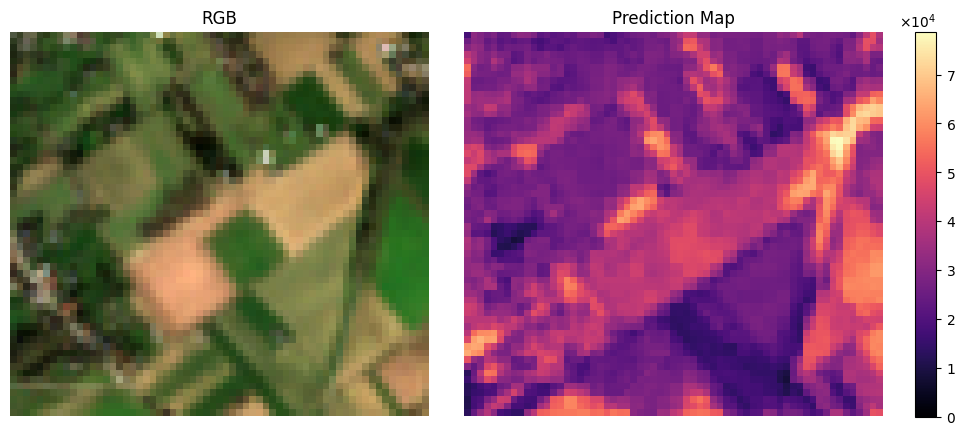

In [21]:
plot_results(prob_map=predictions_map, path_to_input_file=inference_file, task=task_type, ts_index=5)

### Binary task: crop/no-crop

Now we test the few-shot learning on a binary task. We Fine-Tune presto on datapoints sampled from Flanders on 2021. This time, the dataset is the result of a monthly compositing. We initialize the parameters for the dataset preparation accordingly  

##### Presto datasets initialization

In [59]:
parquet_file = "/home/giorgia/Private/data/worldcereal/month/subset/"
task_type = "binary"
target_name = "LANDCOVER_LABEL"
composite_window = "month"

df = load_dataset(parquet_file, composite_window=composite_window)
train_df, val_df, test_df = train_test_val_split(df=df, uniform_sample_by=target_name, sampling_frac=0.8)

  0%|          | 0/1 [00:00<?, ?it/s]

The following features are missing and are filled with NODATAVALUE: ['OPTICAL-B8A']
100%|██████████| 1/1 [00:05<00:00,  5.06s/it]
2025-04-23 17:46:32.803 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:278 - Training set size: 27025
2025-04-23 17:46:32.804 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:279 - Validation set size: 3378
2025-04-23 17:46:32.805 | INFO     | scaleagdata_vito.presto.utils:train_test_val_split:280 - Test set size: 3378


In the context of a binary classification task, specifying the upper and lower bounds won't be necessary anymore. In case we are dealing with multiclass labels, we can convert the problem into a binary classification task by providing the `positive_labels` argument to the `ScaleAgDatset` class. The list of labels passed as value to `positive_labels` indicates which subset of classes should be interpreted as positive class (here "crop"). All the other labels will therefore be interpreted as negative class (here "no-crop").

In [ ]:
num_timesteps = df.available_timesteps.max()
positive_labels = [10, 11, 12, 13]

In [ ]:
train_ds = ScaleAgDataset(
    train_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    positive_labels=positive_labels,
    composite_window=composite_window,
)

val_ds = ScaleAgDataset(
    val_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    positive_labels=positive_labels,
    composite_window=composite_window,
)

test_ds = ScaleAgDataset(
    test_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    positive_labels=positive_labels,
    composite_window=composite_window,
)

2025-04-23 17:46:45.173 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:139 - Setting number of outputs to 1 for binary task.
2025-04-23 17:46:45.185 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:139 - Setting number of outputs to 1 for binary task.


2025-04-23 17:46:45.190 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:139 - Setting number of outputs to 1 for binary task.


##### Presto Finetuning

In this section Presto will be Fine-Tuned in a supervised way for the target downstream task. Once again, we set up the experiment parameters.

In [ ]:
pretrained_model_path = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/scaleagdata/models/presto-ss-wc_30D.pt"
# pretrained_model_path = "/home/giorgia/Private/data/worldcereal/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt"

experiment_name = "presto_wc_ft_crop"
model_output_dir = Path("/home/giorgia/Private/models_FSL/worldcereal/")

In [ ]:
finetuned_model = finetune_on_task(
                train_ds=train_ds,
                val_ds=val_ds,
                pretrained_model_path=pretrained_model_path,
                output_dir=model_output_dir, 
                experiment_name=experiment_name,
            )
evaluate_finetuned_model(finetuned_model, test_ds, num_workers=2, batch_size=32)

2025-04-23 17:48:02.831 | INFO     | scaleagdata_vito.presto.utils:finetune_on_task:199 - Finetuning the model on binary task
2025-04-23 17:48:02.835 | INFO     | prometheo.finetune:_setup:171 - Using output dir: /data/users/Private/giorgia/models_FSL/worldcereal


Finetuning:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 17:49:38.578 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 1/50: Train metric: 0.551, Val metric: 0.440, Best Val Loss: 0.440 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 17:51:26.591 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 2/50: Train metric: 0.439, Val metric: 0.420, Best Val Loss: 0.420 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 17:53:03.752 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 3/50: Train metric: 0.426, Val metric: 0.411, Best Val Loss: 0.411 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 17:54:40.606 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 4/50: Train metric: 0.421, Val metric: 0.406, Best Val Loss: 0.406 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 17:56:16.430 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 5/50: Train metric: 0.415, Val metric: 0.403, Best Val Loss: 0.403 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 17:58:35.332 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 6/50: Train metric: 0.412, Val metric: 0.400, Best Val Loss: 0.400 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:00:33.043 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 7/50: Train metric: 0.408, Val metric: 0.400, Best Val Loss: 0.400 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:02:13.980 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 8/50: Train metric: 0.405, Val metric: 0.394, Best Val Loss: 0.394 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:03:52.981 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 9/50: Train metric: 0.403, Val metric: 0.392, Best Val Loss: 0.392 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:05:30.094 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 10/50: Train metric: 0.401, Val metric: 0.390, Best Val Loss: 0.390 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:07:38.169 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 11/50: Train metric: 0.399, Val metric: 0.390, Best Val Loss: 0.390 (no improvement for 1 epochs)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:09:26.711 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 12/50: Train metric: 0.398, Val metric: 0.387, Best Val Loss: 0.387 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:11:27.914 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 13/50: Train metric: 0.396, Val metric: 0.384, Best Val Loss: 0.384 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:13:01.981 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 14/50: Train metric: 0.396, Val metric: 0.384, Best Val Loss: 0.384 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:14:37.931 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 15/50: Train metric: 0.394, Val metric: 0.386, Best Val Loss: 0.384 (no improvement for 1 epochs)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:16:17.473 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 16/50: Train metric: 0.393, Val metric: 0.382, Best Val Loss: 0.382 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:18:57.059 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 17/50: Train metric: 0.392, Val metric: 0.380, Best Val Loss: 0.380 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:20:38.055 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 18/50: Train metric: 0.391, Val metric: 0.379, Best Val Loss: 0.379 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:22:39.023 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 19/50: Train metric: 0.390, Val metric: 0.380, Best Val Loss: 0.379 (no improvement for 1 epochs)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:24:16.884 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 20/50: Train metric: 0.390, Val metric: 0.378, Best Val Loss: 0.378 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:25:54.772 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 21/50: Train metric: 0.388, Val metric: 0.377, Best Val Loss: 0.377 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:27:33.634 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 22/50: Train metric: 0.387, Val metric: 0.375, Best Val Loss: 0.375 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff0fb0360e0>
Traceback (most recent call last):
  File "/home/giorgia/.conda/envs/veg/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/giorgia/.conda/envs/veg/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/home/giorgia/.conda/envs/veg/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ff0fb0360e0>
Traceback (most recent call last):
  File "/home/giorgia/.conda/envs/veg/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/home/giorgia/.conda/envs/veg/lib/python3.10/site-packages/to

Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:31:34.210 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 24/50: Train metric: 0.386, Val metric: 0.373, Best Val Loss: 0.373 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:33:31.348 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 25/50: Train metric: 0.386, Val metric: 0.371, Best Val Loss: 0.371 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:35:08.705 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 26/50: Train metric: 0.384, Val metric: 0.372, Best Val Loss: 0.371 (no improvement for 1 epochs)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:37:05.998 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 27/50: Train metric: 0.383, Val metric: 0.370, Best Val Loss: 0.370 (improved)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:38:40.772 | INFO     | prometheo.finetune:_train_loop:126 - PROGRESS after Epoch 28/50: Train metric: 0.383, Val metric: 0.370, Best Val Loss: 0.370 (no improvement for 1 epochs)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

2025-04-23 18:40:16.215 | INFO     | prometheo.finetune:_train_loop:111 - Early stopping!
2025-04-23 18:40:16.294 | INFO     | prometheo.finetune:run_finetuning:274 - Finetuning done
2025-04-23 18:40:16.297 | INFO     | scaleagdata_vito.presto.utils:evaluate_finetuned_model:103 - Evaluating the finetuned model on binary task


{'0.0': {'precision': 0.7424593967517401,
  'recall': 0.6361829025844931,
  'f1-score': 0.6852248394004282,
  'support': 1006.0},
 '1.0': {'precision': 0.8545310015898251,
  'recall': 0.9064080944350759,
  'f1-score': 0.8797054009819967,
  'support': 2372.0},
 'accuracy': 0.8259325044404974,
 'macro avg': {'precision': 0.7984951991707826,
  'recall': 0.7712954985097844,
  'f1-score': 0.7824651201912125,
  'support': 3378.0},
 'weighted avg': {'precision': 0.8211550292786606,
  'recall': 0.8259325044404974,
  'f1-score': 0.8217872704458634,
  'support': 3378.0}}

##### Inference using Fine-Tuned end-to-end Presto

We now apply the finetuned model to an unseen area to perform the classification task.

In [ ]:
finetuned_model = load_finetuned_model(model_output_dir / experiment_name, task_type=task_type)
inference_file = Path("/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_preprocessed_inputs.nc")

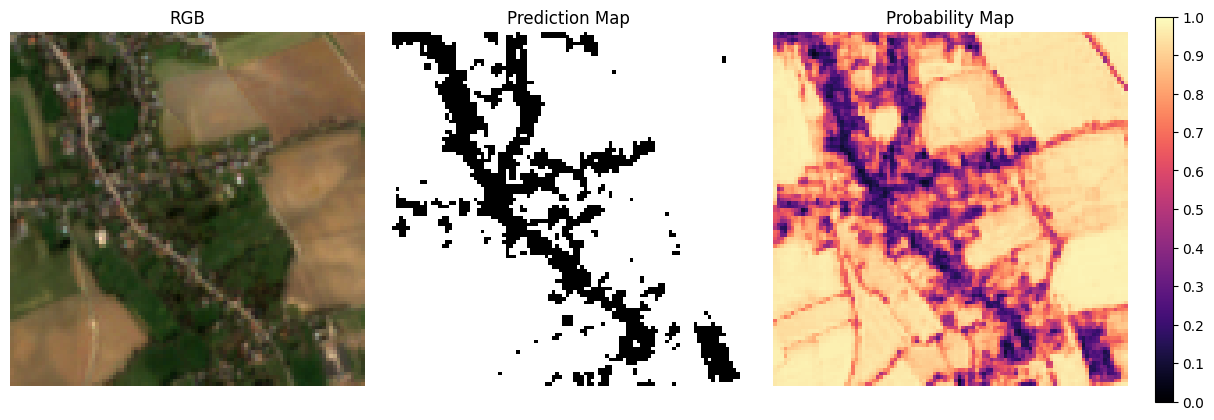

In [67]:
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    composite_window=composite_window,
)

predictions = presto_model.predict(inference_file)
prob_map = reshape_result(predictions, path_to_input_file=inference_file)
pred_map = presto_model.get_predictions(prob_map, threshold=0.5)
plot_results(prob_map=prob_map, pred_map=pred_map, path_to_input_file=inference_file, task=task_type, ts_index=4)